In [80]:
import pandas as pd
import numpy as np
import config
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm

import pickle
import json

import warnings
warnings.filterwarnings("ignore")

# 1. Problem Statement

# 2. Data Gathering

In [7]:
df = pd.read_csv(config.CSV_FILE_PATH)
df.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 'State', 'Profit'], dtype='object')

In [8]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


# 3. Exploratory DATA Analysis

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


<AxesSubplot: >

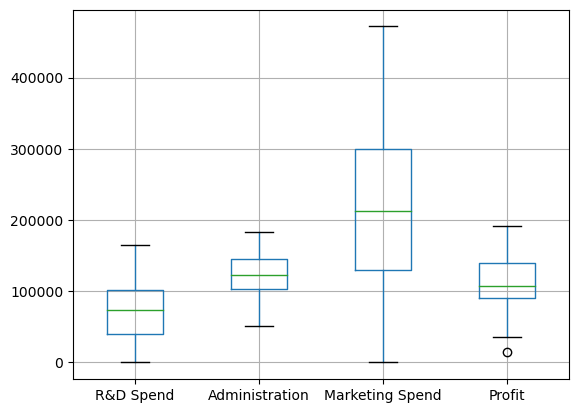

In [13]:
df.boxplot()

In [14]:
df.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [15]:
df.isna().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

# 4. Feature Engineering

In [16]:
df["State"].value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

In [ ]:
df = pd.get_dummies(df, columns = ["State"])

In [21]:
df.tail()

,R&D Spend,Administration,Marketing Spend,Profit,State_California,State_Florida,State_New York
45,1000.23,124153.04,1903.93,64926.08,0,0,1
46,1315.46,115816.21,297114.46,49490.75,0,1,0
47,0.00,135426.92,0.00,42559.73,1,0,0
48,542.05,51743.15,0.00,35673.41,0,0,1
49,0.00,116983.80,45173.06,14681.40,1,0,0


# 5. Feature Selection

### 5.1 Linearity

In [22]:
df.corr()

,R&D Spend,Administration,Marketing Spend,Profit,State_California,State_Florida,State_New York
R&D Spend,1.000000,0.241955,0.724248,0.972900,-0.143165,0.105711,0.039068
Administration,0.241955,1.000000,-0.032154,0.200717,-0.015478,0.010493,0.005145
Marketing Spend,0.724248,-0.032154,1.000000,0.747766,-0.168875,0.205685,-0.033670
Profit,0.972900,0.200717,0.747766,1.000000,-0.145837,0.116244,0.031368
State_California,-0.143165,-0.015478,-0.168875,-0.145837,1.000000,-0.492366,-0.515152
State_Florida,0.105711,0.010493,0.205685,0.116244,-0.492366,1.000000,-0.492366
State_New York,0.039068,0.005145,-0.033670,0.031368,-0.515152,-0.492366,1.000000


In [23]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), annot = True)
plt.savefig("Correlation.png")

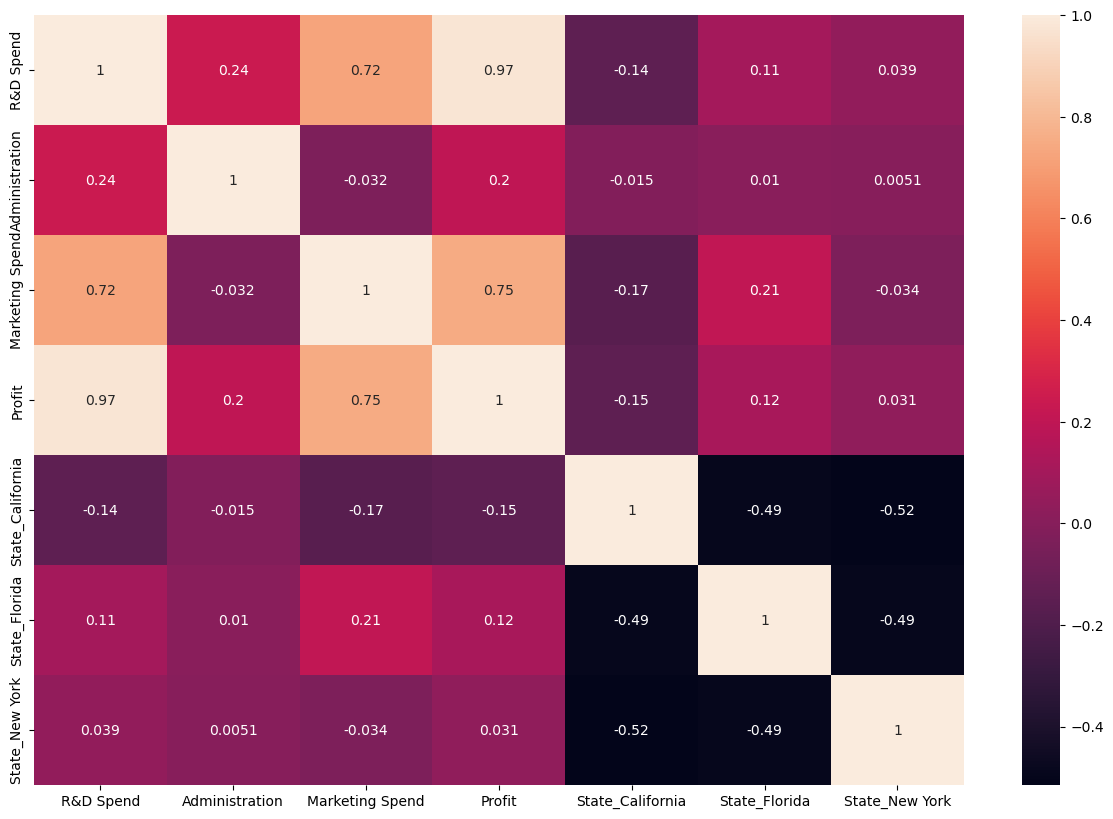

In [24]:
plt.show()

### 5.2 No Multicolinearity

In [25]:
df1 = df.drop("Profit",axis = 1)

In [28]:
for i in range(df1.shape[1]):
    vif = variance_inflation_factor(df1.to_numpy(), i)
    print(f"VIF for {df1.columns[i]}:",vif)

VIF for R&D Spend: 2.4955109215494433
VIF for Administration: 1.1777660508993841
VIF for Marketing Spend: 2.4167967566863946
VIF for State_California: 9.044051986598609
VIF for State_Florida: 9.44357838439795
VIF for State_New York: 9.222969024865256


In [31]:
vif_list = []
for i in range(df1.shape[1]):
    vif = variance_inflation_factor(df1.to_numpy(), i)
    vif_list.append(vif)
    
s1 = pd.Series(vif_list,index =df1.columns)
s1.sort_values().plot(kind = 'barh')

<AxesSubplot: >

# 6. Model Training

### 6.1 Train Test Split

In [32]:
x = df1
y = df["Profit"]

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=22)

### 6.2 Instantiating Linear Regression Model

In [34]:
linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)

LinearRegression()

# 7. Evaluation

### 7.1 Evaluation on Testing Dataset

In [35]:
y_pred_test = linear_reg.predict(x_test)

mse = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error :",mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error :",rmse)

mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error :",mae)

r_squared = r2_score(y_test, y_pred_test)
print("R Squared Value is :",r_squared)

Mean Squared Error : 42184386.72956334
Root Mean Squared Error : 6494.950864291688
Mean Absolute Error : 5315.621346703805
R Squared Value is : 0.9757906394981232


### 7.2 Evaluation on Training Dataset

In [37]:
y_pred_train = linear_reg.predict(x_train)

mse = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error :",mse)

rmse = np.sqrt(mse)
print("Root Mean Squared Error :",rmse)

mae = mean_absolute_error(y_train, y_pred_train)
print("Mean Absolute Error :",mae)

r_squared = r2_score(y_train, y_pred_train)
print("R Squared Value is :",r_squared)

Mean Squared Error : 88672903.87452212
Root Mean Squared Error : 9416.629114206533
Mean Absolute Error : 6809.391332727268
R Squared Value is : 0.9425908513252553


# Normality of Residuals

In [82]:
Residual = y_train - y_pred_train


<AxesSubplot: xlabel='Profit', ylabel='Density'>

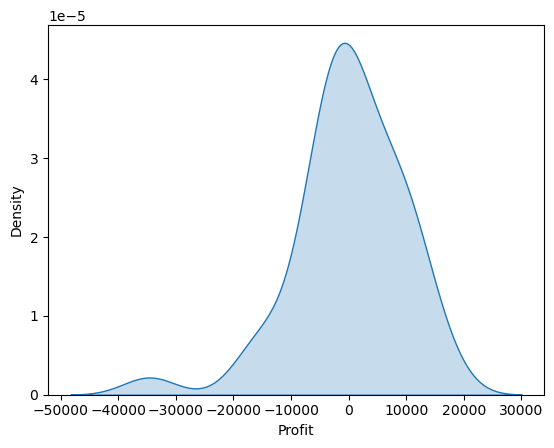

In [83]:
sns.kdeplot(Residual, fill= True)

<AxesSubplot: xlabel='Profit', ylabel='Count'>

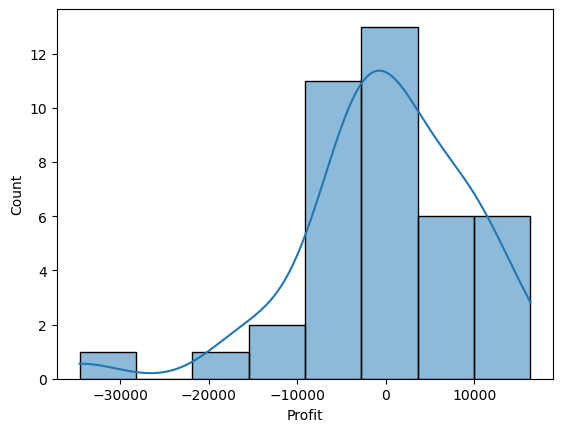

In [84]:
sns.histplot(Residual,kde=True)

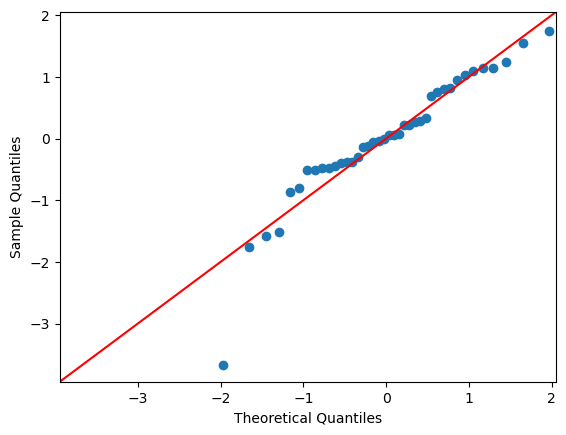

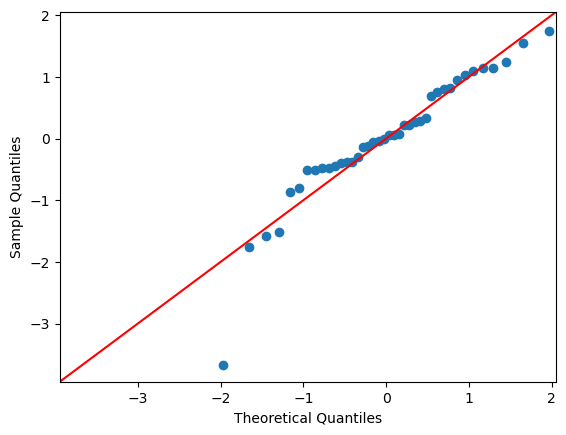

In [85]:
sm.qqplot(Residual, line = "45", fit = True)

# Homoscedasticity

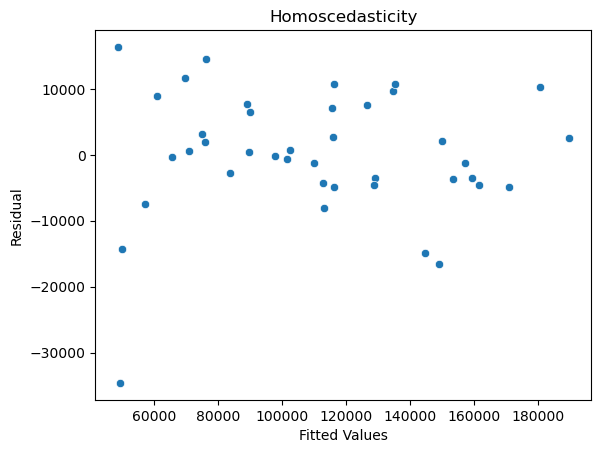

In [86]:
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Homoscedasticity")
sns.scatterplot(x = y_pred_train, y = Residual)
plt.savefig("Homoscedasticity.png")

### Testing on User Inputs

In [38]:
df.head(1).T

,0
R&D Spend,165349.20
Administration,136897.80
Marketing Spend,471784.10
Profit,192261.83
State_California,0.00
State_Florida,0.00
State_New York,1.00


In [57]:
project_data = {"Columns": x.columns.tolist()}
project_data

{'Columns': ['R&D Spend',
  'Administration',
  'Marketing Spend',
  'State_California',
  'State_Florida',
  'State_New York']}

In [60]:
RD_Spend        =165349.20
Administration  =136897.80
Marketing_Spend =471784.10
State           ='New York'

State = "State_"+State

State_index = project_data["Columns"] == State

test_array = np.zeros(x.shape[1])
test_array[0] = RD_Spend
test_array[1] = Administration
test_array[2] = Marketing_Spend
test_array[State_index] = 1

Profit_Prediction = np.around(linear_reg.predict([test_array])[0],2)
Profit_Prediction

190163.32

In [55]:
with open("Linear_reg_model.pkl","wb") as f:
    pickle.dump(linear_reg,f)

In [61]:
with open("Project_data.json","w") as f:
    json.dump(project_data,f)